# Training Models

In [1]:
#Importing Libraries
import sys
import os
import numpy as np
import pandas as pd
import mlflow
import os

In [2]:
#Jupyter Notebook Settings
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import plot_tree
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score


In [4]:
os.getcwd()


'c:\\Users\\milky\\Desktop\\10Academy\\Week 2\\abtest-mlops\\notebooks'

In [5]:
#importing local scripts
#Adding scripts path
sys.path.append(os.path.abspath(os.path.join('..')))
#importing data_manipulator script
from scripts.model_info_extractor import *
from scripts.ml_modelling_utils import *

## Importing and Fixing Data

In [6]:
#Importing the collected Data
path = 'data/AdSmartABdata.csv'
repo = 'https://github.com/DePacifier/abtest-mlops'
all_dfs = import_all_data_using_tagslist(path=path, repo=repo, tags=[
                                         'chrome-mobile', 'chrome-mobile-view', 'facebook', 'samsung-internet', 'platform-6'])


In [7]:
all_dfs['chrome-mobile'].head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,378645d2-f8cf-43c0-b1be-e699d846e596,control,2020-07-04,6,Generic Smartphone,6,Chrome Mobile,0
1,ef334830-f200-4c1b-aea2-b01b96ca0950,exposed,2020-07-03,12,Generic Smartphone,6,Chrome Mobile,0
2,49e7690d-4825-499c-9553-756af3198a10,control,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,1
3,80b9fecc-ef23-4896-bd43-b81c074f49c3,control,2020-07-09,17,Generic Smartphone,6,Chrome Mobile,1
4,3dd09b49-9b11-45bd-ab0d-e279a8e5edc7,exposed,2020-07-03,0,Generic Smartphone,6,Chrome Mobile,0


In [8]:
# Spliting the date column to year, month and day columns and removing it
all_dfs_date_fixed = split_date_to_numbers(all_dfs, 'date')
all_dfs_date_fixed['chrome-mobile'].head(5)

,auction_id,experiment,hour,device_make,platform_os,browser,response,year,month,day
0,378645d2-f8cf-43c0-b1be-e699d846e596,control,6,Generic Smartphone,6,Chrome Mobile,0,2020,7,4
1,ef334830-f200-4c1b-aea2-b01b96ca0950,exposed,12,Generic Smartphone,6,Chrome Mobile,0,2020,7,3
2,49e7690d-4825-499c-9553-756af3198a10,control,10,Generic Smartphone,6,Chrome Mobile,1,2020,7,7
3,80b9fecc-ef23-4896-bd43-b81c074f49c3,control,17,Generic Smartphone,6,Chrome Mobile,1,2020,7,9
4,3dd09b49-9b11-45bd-ab0d-e279a8e5edc7,exposed,0,Generic Smartphone,6,Chrome Mobile,0,2020,7,3


In [9]:
#drop columns from each data, the grouping column b/c its a univalue column
#We have 5 dataframes of which 4 are grouped based on browser and 1 based on platform
for i in all_dfs_date_fixed:
    if(i != "platform-6"):
        all_dfs_date_fixed[i].drop('browser', axis=1, inplace=True)
    else:
        all_dfs_date_fixed[i].drop('platform_os', axis=1, inplace=True)

In [10]:

data_type_fixed_dfs = change_columns_to_numbers(all_dfs_date_fixed, ['experiment', 'device_make', 'browser'])
data_type_fixed_dfs['platform-6'].sample(5)


,auction_id,experiment,hour,device_make,browser,response,year,month,day
104,90e88134-b9bc-4655-99d1-3f73b124c1bc,1,15,13,1,1,2020,7,10
607,392c7d83-0487-4bdb-bea2-f7639ea74aa6,0,6,13,1,0,2020,7,7
568,fd86fc6b-3420-4f81-9df0-98fa1f15abf5,1,17,69,3,0,2020,7,8
153,dc51cfac-0e3d-4158-9e1f-951466cba76b,0,15,65,5,1,2020,7,3
471,3921160f-6412-43fd-8ccf-6bb96630b2f5,1,19,68,5,1,2020,7,8


In [11]:
# #Get all train, validate and test sets
chrome_mobile_dict = get_train_validate_test_sets(data_type_fixed_dfs['chrome-mobile'], predicted_column='response', remove_columns=['auction_id'])
chrome_mobile_view_dict = get_train_validate_test_sets(data_type_fixed_dfs['chrome-mobile-view'], predicted_column='response', remove_columns=['auction_id'])
facebook_dict = get_train_validate_test_sets(data_type_fixed_dfs['facebook'], predicted_column='response', remove_columns=['auction_id'])
samsung_internet_dict = get_train_validate_test_sets(data_type_fixed_dfs['samsung-internet'], predicted_column='response', remove_columns=['auction_id'])
platform_6_dict = get_train_validate_test_sets(data_type_fixed_dfs['platform-6'], predicted_column='response', remove_columns=['auction_id'])

In [12]:
chrome_mobile_dict['train_x'].head()


,experiment,hour,device_make,platform_os,year,month,day
2,0,10,1,6,2020,7,7
21,0,15,1,6,2020,7,3
509,1,2,9,6,2020,7,6
231,1,3,1,6,2020,7,9
503,1,19,1,6,2020,7,5


# Training

> Training only done for 4 or the 5 data(samsung-internet is omitted)

## Logistic Regression Model

In [13]:
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

In [14]:
# # For chrome mobile
# import warnings
# warnings.filterwarnings('ignore')
chrome_mobile_model = train_logistic_model(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])


In [15]:
get_lr_model_evaluation(
    chrome_mobile_model, chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'], chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'], True)
# .score(
#     chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'])


Validation Accuracy : 0.504
Validation Confusion Matrix:
[[55  4]
 [58  8]]
--------------------------------------------------
Test Accuracy : 0.6285714285714286
Test Confusion Matrix:
[[38  2]
 [24  6]]


(0.504,
 array([[55,  4],
        [58,  8]], dtype=int64),
 0.6285714285714286,
 array([[38,  2],
        [24,  6]], dtype=int64))

In [16]:
get_lr_params(chrome_mobile_model)


{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': True}

In [17]:
get_lr_features(chrome_mobile_model, chrome_mobile_dict['val_x'])

,Feature,Score
0,experiment,0.043036
1,hour,0.030049
2,device_make,0.019553
6,day,0.010276
3,platform_os,-0.000001
5,month,-0.000001
4,year,-0.000355


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

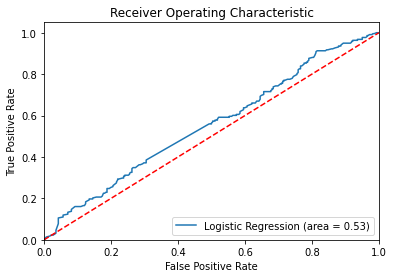

In [18]:
get_lr_model_roc_curve_log(
    chrome_mobile_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

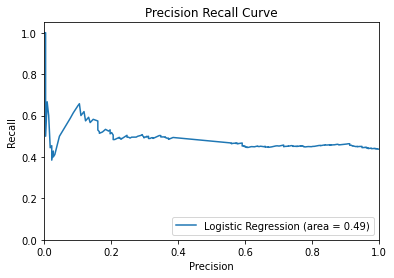

In [19]:
get_lr_model_precision_recall_curve(
    chrome_mobile_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], show=False)


In [20]:
# chrome_mobile_model

In [21]:
# chrome_mobile_view_model = train_logistic_model(
#     chrome_mobile_view_dict['train_x'], chrome_mobile_view_dict['train_y'], chrome_mobile_view_dict['val_x'], chrome_mobile_view_dict['val_y'])


In [22]:
# facebook_model = train_logistic_model(
#     facebook_dict['train_x'], facebook_dict['train_y'], facebook_dict['val_x'], facebook_dict['val_y'])


In [23]:
# samsung_internet_model = train_logistic_model(
#     samsung_internet_dict['train_x'], samsung_internet_dict['train_y'], samsung_internet_dict['val_x'], samsung_internet_dict['val_y'])


In [24]:
platform_6_model = train_logistic_model(
    platform_6_dict['train_x'], platform_6_dict['train_y'], platform_6_dict['val_x'], platform_6_dict['val_y'])


In [25]:
get_lr_model_evaluation(
    platform_6_model, platform_6_dict['val_x'], platform_6_dict['val_y'], platform_6_dict['test_x'], platform_6_dict['test_y'], True)


Validation Accuracy : 0.49321266968325794
Validation Confusion Matrix:
[[84 43]
 [69 25]]
--------------------------------------------------
Test Accuracy : 0.5853658536585366
Test Confusion Matrix:
[[47 20]
 [31 25]]


(0.49321266968325794,
 array([[84, 43],
        [69, 25]], dtype=int64),
 0.5853658536585366,
 array([[47, 20],
        [31, 25]], dtype=int64))

In [26]:
get_lr_params(platform_6_model)


{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': True}

In [27]:
get_lr_features(platform_6_model, platform_6_dict['val_x'])


,Feature,Score
3,browser,5.474603e-02
0,experiment,4.666059e-02
1,hour,2.451687e-02
5,month,-8.461805e-07
2,device_make,-1.573432e-04
4,year,-2.441835e-04
6,day,-2.969990e-03


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

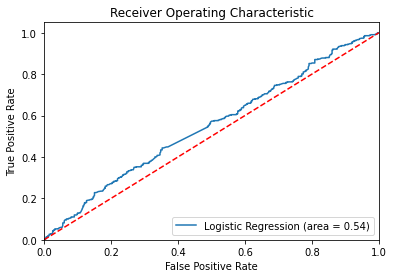

In [28]:
get_lr_model_roc_curve_log(
    platform_6_model, platform_6_dict['train_x'], platform_6_dict['train_y'], show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

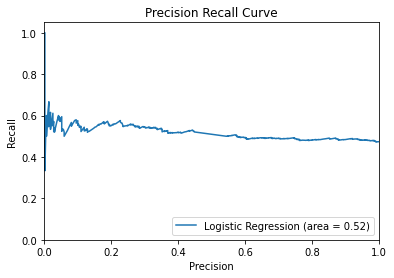

In [29]:
get_lr_model_precision_recall_curve(
    platform_6_model, platform_6_dict['train_x'], platform_6_dict['train_y'], show=False)


## Decision Trees

In [30]:
chrome_mobile_tree_model = train_decision_tree(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [31]:
get_model_evaluation(chrome_mobile_tree_model, chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'], chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'], True)


Validation Accuracy : 0.432
Validation Confusion Matrix:
[[38 21]
 [50 16]]
--------------------------------------------------
Test Accuracy : 0.6142857142857143
Test Confusion Matrix:
[[30 10]
 [17 13]]


(0.432,
 array([[38, 21],
        [50, 16]], dtype=int64),
 0.6142857142857143,
 array([[30, 10],
        [17, 13]], dtype=int64))

In [33]:
get_features(chrome_mobile_tree_model, chrome_mobile_dict['val_x'])


,Feature,Score
0,experiment,0.009709
1,hour,0.009709
2,device_make,0.009709
3,platform_os,0.009709
4,year,0.009709
5,month,0.009709
6,day,0.009709


In [34]:
get_score_df(chrome_mobile_tree_model)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2317,0.002000,1.784161e-07,0.001600,4.907590e-04,None,entropy,7,sqrt,2,7,"{'class_weight': None, 'criterion': 'entropy',...",0.56,0.57,0.57,0.58,0.62,0.580,0.020976,1
2389,0.002201,4.009279e-04,0.001201,3.997357e-04,None,entropy,7,log2,2,7,"{'class_weight': None, 'criterion': 'entropy',...",0.56,0.57,0.57,0.58,0.62,0.580,0.020976,1
0,0.003015,6.323058e-04,0.002009,6.580295e-04,None,gini,3,sqrt,1,2,"{'class_weight': None, 'criterion': 'gini', 'm...",0.54,0.56,0.58,0.61,0.58,0.574,0.023324,3
1,0.003800,7.483921e-04,0.002000,4.422006e-07,None,gini,3,sqrt,1,3,"{'class_weight': None, 'criterion': 'gini', 'm...",0.54,0.56,0.58,0.61,0.58,0.574,0.023324,3
2,0.002801,7.485329e-04,0.002200,7.487374e-04,None,gini,3,sqrt,1,4,"{'class_weight': None, 'criterion': 'gini', 'm...",0.54,0.56,0.58,0.61,0.58,0.574,0.023324,3


In [35]:
get_model_best_score(chrome_mobile_tree_model)


0.58

In [36]:
get_model_best_estimator(chrome_mobile_tree_model)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=7,
                       random_state=42)

In [37]:
get_best_model_parameters(chrome_mobile_tree_model)


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7}

<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

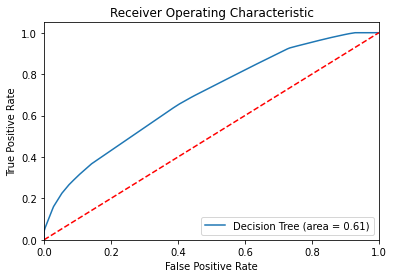

In [38]:
get_model_roc_curve_log(
    chrome_mobile_tree_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'],"Decision Tree", show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

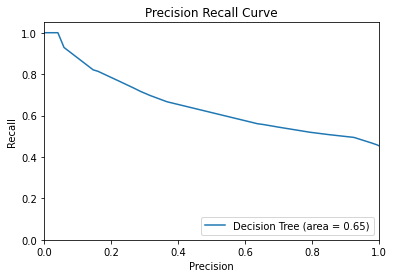

In [39]:
get_model_precision_recall_curve(
    chrome_mobile_tree_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], "Decision Tree", show=False)


In [40]:
# chrome_mobile_view_tree_model = train_decision_tree(
#     chrome_mobile_view_dict['train_x'], chrome_mobile_view_dict['train_y'], chrome_mobile_view_dict['val_x'], chrome_mobile_view_dict['val_y'])


In [41]:
# facebook_tree_model = train_decision_tree(
#     facebook_dict['train_x'], facebook_dict['train_y'], facebook_dict['val_x'], facebook_dict['val_y'])


In [42]:
# samsung_internet_tree_model = train_decision_tree(
#     samsung_internet_dict['train_x'], samsung_internet_dict['train_y'], samsung_internet_dict['val_x'], samsung_internet_dict['val_y'])


In [43]:
platform_6_tree_model = train_decision_tree(
    platform_6_dict['train_x'], platform_6_dict['train_y'], platform_6_dict['val_x'], platform_6_dict['val_y'])


Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [44]:
get_score_df(platform_6_tree_model)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3171,0.004209,9.775217e-04,0.001991,6.334592e-04,None,entropy,13,sqrt,1,5,"{'class_weight': None, 'criterion': 'entropy',...",0.542373,0.497175,0.602273,0.602273,0.556818,0.560182,0.039602,1
3243,0.003000,8.714517e-07,0.001000,3.504023e-07,None,entropy,13,log2,1,5,"{'class_weight': None, 'criterion': 'entropy',...",0.542373,0.497175,0.602273,0.602273,0.556818,0.560182,0.039602,1
2912,0.003636,5.216021e-04,0.001563,5.014885e-04,None,entropy,11,sqrt,5,2,"{'class_weight': None, 'criterion': 'entropy',...",0.519774,0.480226,0.602273,0.607955,0.568182,0.555682,0.049076,3
2913,0.003167,7.160674e-04,0.001835,4.207516e-04,None,entropy,11,sqrt,5,3,"{'class_weight': None, 'criterion': 'entropy',...",0.519774,0.480226,0.602273,0.607955,0.568182,0.555682,0.049076,3
2914,0.007394,7.865590e-03,0.002601,1.356424e-03,None,entropy,11,sqrt,5,4,"{'class_weight': None, 'criterion': 'entropy',...",0.519774,0.480226,0.602273,0.607955,0.568182,0.555682,0.049076,3


In [45]:
get_model_evaluation(platform_6_tree_model,
                     platform_6_dict['val_x'], platform_6_dict['val_y'], platform_6_dict['test_x'], platform_6_dict['test_y'], True)


Validation Accuracy : 0.49321266968325794
Validation Confusion Matrix:
[[71 56]
 [56 38]]
--------------------------------------------------
Test Accuracy : 0.5121951219512195
Test Confusion Matrix:
[[43 24]
 [36 20]]


(0.49321266968325794,
 array([[71, 56],
        [56, 38]], dtype=int64),
 0.5121951219512195,
 array([[43, 24],
        [36, 20]], dtype=int64))

In [46]:
get_features(platform_6_tree_model, platform_6_dict['val_x'])


,Feature,Score
0,experiment,0.028702
1,hour,0.028702
2,device_make,0.028702
3,browser,0.028702
4,year,0.028702
5,month,0.028702
6,day,0.028702


In [47]:
get_model_best_score(platform_6_tree_model)


0.5601823317925012

In [48]:
get_model_best_estimator(platform_6_tree_model)


DecisionTreeClassifier(criterion='entropy', max_depth=13, max_features='sqrt',
                       min_samples_split=5, random_state=42)

In [49]:
get_best_model_parameters(platform_6_tree_model)


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5}

<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

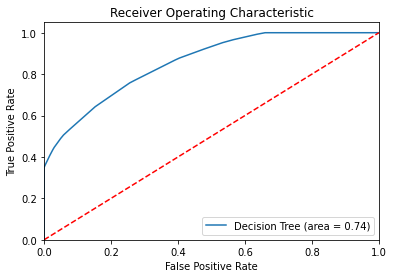

In [50]:
get_model_roc_curve_log(
    platform_6_tree_model, platform_6_dict['train_x'], platform_6_dict['train_y'], "Decision Tree", show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

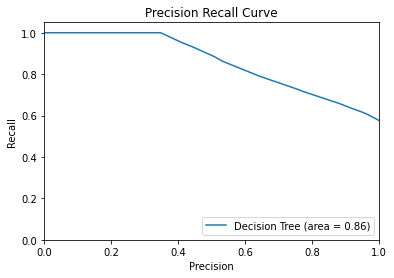

In [51]:
get_model_precision_recall_curve(
    platform_6_tree_model, platform_6_dict['train_x'], platform_6_dict['train_y'], "Decision Tree", show=False)


## XGB Boost

In [52]:
# chrome_mobile_xgbc_model = train_xgb_classifier(
#     chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])


## Too Much Compution Time Required to train xgb classifier with these parameters

In [53]:
# chrome_mobile_view_xgbc_model = train_xgb_classifier(
#     chrome_mobile_view_dict['train_x'], chrome_mobile_view_dict['train_y'], chrome_mobile_view_dict['val_x'], chrome_mobile_view_dict['val_y'])


In [54]:
# facebook_xgbc_model = train_xgb_classifier(
#     facebook_dict['train_x'], facebook_dict['train_y'], facebook_dict['val_x'], facebook_dict['val_y'])


In [55]:
# samsung_internet_xgbc_model = train_xgb_classifier(
#     samsung_internet_dict['train_x'], samsung_internet_dict['train_y'], samsung_internet_dict['val_x'], samsung_internet_dict['val_y'])


In [56]:
# platform_6_xgbc_model = train_xgb_classifier(
#     platform_6_dict['train_x'], platform_6_dict['train_y'], platform_6_dict['val_x'], platform_6_dict['val_y'])
